Cut_in_series get data

Filter:

isCutIn = stdDevLat > 0.5                
          & minDistLat < 2             
          & maxDiffObj < 0.5            
          & ~isCutOut                   
          & max(abs(...)) > 2.5         
          & maxLateralMovement > 2.5;   


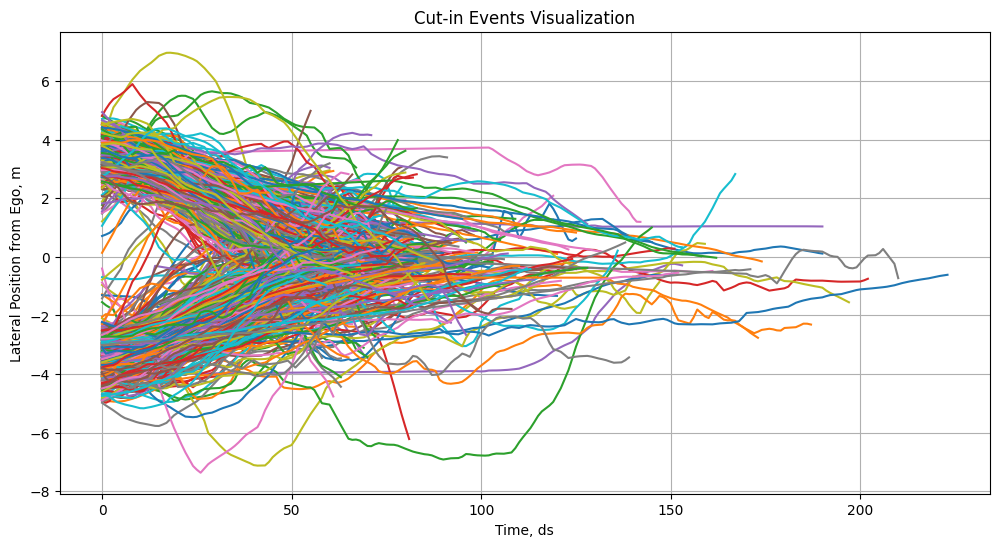

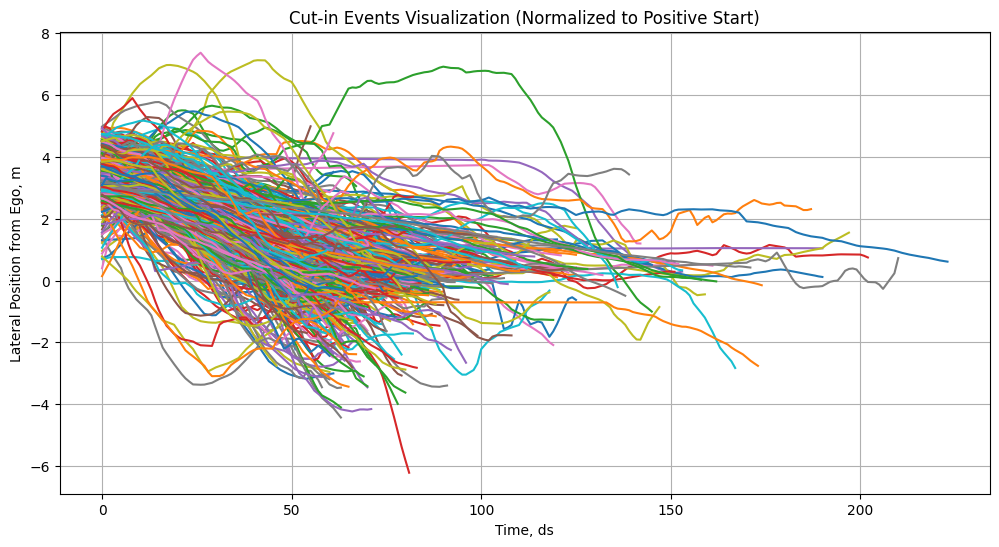

Number of change direction: 622


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


file_path = 'cutin_results_1111.csv'
data = pd.read_csv(file_path, sep=';')  
CUTIN_objV2PosYM = data['objV2PosYM'].to_numpy()  

data['label_start_time'] = data['label_start_time'].astype(float)
data['objV2PosYM'] = data['objV2PosYM'].astype(float)
unique_cutins = data['cutin_id'].unique()

plt.figure(figsize=(12, 6))

for cutin_id in unique_cutins:
    cutin_data = data[data['cutin_id'] == cutin_id]
    time_zeroed = cutin_data['tRelMs'] - cutin_data['tRelMs'].iloc[0]
    plt.plot(time_zeroed/100, cutin_data['objV2PosYM'])

plt.title('Cut-in Events Visualization')
plt.xlabel('Time, ds')
plt.ylabel('Lateral Position from Ego, m')
plt.grid(True)

plt.show()

count_N = 0

plt.figure(figsize=(12, 6))

for cutin_id in unique_cutins:
    cutin_data = data[data['cutin_id'] == cutin_id]
    time_zeroed = (cutin_data['tRelMs'] - cutin_data['tRelMs'].iloc[0]) / 100  # 单位: ds
    y = cutin_data['objV2PosYM'].to_numpy()

    if y[0] < 0:
        y = -y
        count_N +=1

    plt.plot(time_zeroed, y)

plt.title('Cut-in Events Visualization (Normalized to Positive Start)')
plt.xlabel('Time, ds')
plt.ylabel('Lateral Position from Ego, m')
plt.grid(True)
plt.show()
print(f"Number of change direction: {count_N}")

Data classificaton

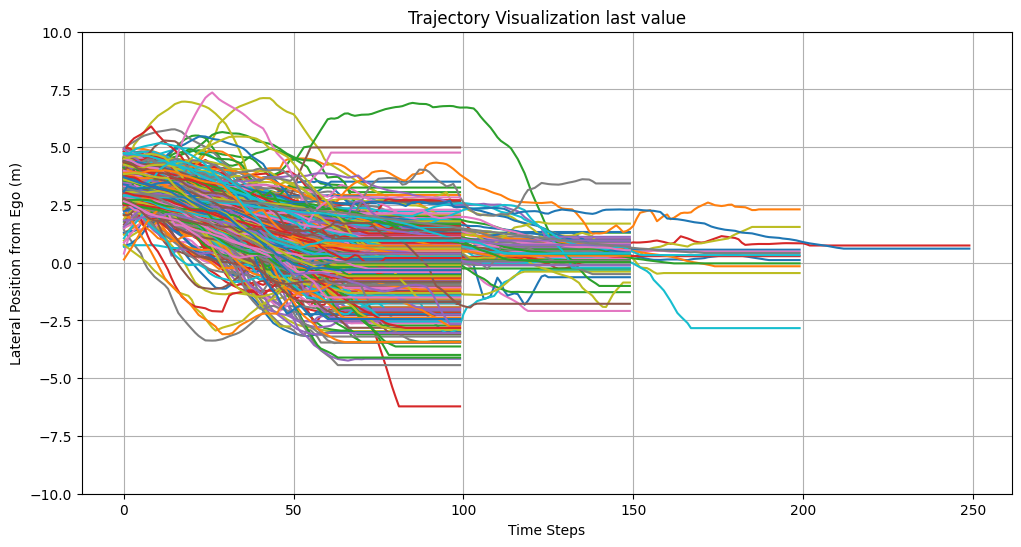

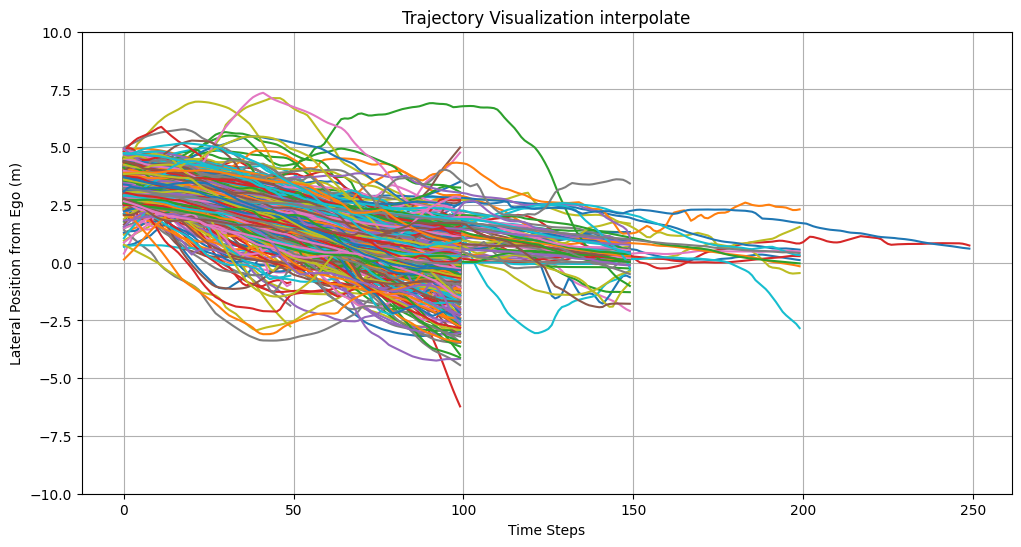

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
from nflows.distributions.normal import StandardNormal
from nflows.flows.base import Flow
from nflows.transforms import CompositeTransform, MaskedAffineAutoregressiveTransform, ReversePermutation

data = pd.read_csv('cutin_results_1111.csv', sep=';')
data['cutin_id'] = data['cutin_id'].astype(str)
data['objV2PosYM'] = data['objV2PosYM'].astype(float)
data['tRelMs'] = data['tRelMs'].astype(float)

trajectory_list_last = []
trajectory_list_inter = []
trajectory_dict_last = {}
trajectory_dict_inter = {}

for cutin_id in data['cutin_id'].unique():
    group = data[data['cutin_id'] == cutin_id].sort_values(by='tRelMs')
    y = group['objV2PosYM'].to_numpy()
    if y[0] < 0:
        y = -y  # normalize direction
     # Determine the length of the trajectory
    length = len(y)
    target_length = ((length // 50) + 1) * 50  # Round up to the next multiple of 50

    # fulfill with the last value
    trajectory = np.full(target_length, y[-1])  
    trajectory[:length] = y  
    trajectory_list_last.append(trajectory)
    if target_length not in trajectory_dict_last:
        trajectory_dict_last[target_length] = []
    trajectory_dict_last[target_length].append(trajectory)

plt.figure(figsize=(12, 6))

for i, trajectory in enumerate(trajectory_list_last):
    plt.plot(trajectory, label=f'Trajectory {i+1}')

plt.title('Trajectory Visualization last value')
plt.xlabel('Time Steps')
plt.ylabel('Lateral Position from Ego (m)')
plt.grid(True)
plt.ylim(-10, 10)
plt.show()

for cutin_id in data['cutin_id'].unique():
    group = data[data['cutin_id'] == cutin_id].sort_values(by='tRelMs')
    y = group['objV2PosYM'].to_numpy()
    if y[0] < 0:
        y = -y  # normalize direction
     # Determine the length of the trajectory
    length = len(y)
    target_length = ((length // 50) + 1) * 50  # Round up to the next multiple of 50

    # Interpolate to the target length
    trajectory = np.interp(np.linspace(0, length - 1, target_length), np.arange(length), y)
    trajectory_list_inter.append(trajectory)
    if target_length not in trajectory_dict_inter:
        trajectory_dict_inter[target_length] = []
    trajectory_dict_inter[target_length].append(trajectory)

plt.figure(figsize=(12, 6))

for i, trajectory in enumerate(trajectory_list_inter):
    plt.plot(trajectory, label=f'Trajectory {i+1}')

plt.title('Trajectory Visualization interpolate')
plt.xlabel('Time Steps')
plt.ylabel('Lateral Position from Ego (m)')
plt.grid(True)
plt.ylim(-10, 10)
plt.show()



NF training

In [3]:
models = {}
trajectory_dict = trajectory_dict_inter
for length, trajectories in trajectory_dict.items():
    trajectory_array = np.stack(trajectories)  # shape: [num_samples, time_steps]

    if len(trajectories) < 20:
        continue

    print(f"Training model for trajectory length: {length}, Number of samples: {len(trajectories)}")

    pca = PCA(n_components = 5)
    trajectory_latent = pca.fit_transform(trajectory_array)

    latent_dim = trajectory_latent.shape[1]
    base_dist = StandardNormal([latent_dim])

    transforms = []
    for _ in range(4):  
        transforms.append(ReversePermutation(features=latent_dim))
        transforms.append(MaskedAffineAutoregressiveTransform(features=latent_dim, hidden_features=64))
    transform = CompositeTransform(transforms)
    flow = Flow(transform, base_dist)

    x_train = torch.tensor(trajectory_latent, dtype=torch.float32)

    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
    for epoch in range(500):
        optimizer.zero_grad()
        loss = -flow.log_prob(x_train).mean()
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    models[length] = (flow, pca)



Training model for trajectory length: 100, Number of samples: 1011
Epoch 0, Loss: 20.2456
Epoch 100, Loss: 9.8962
Epoch 200, Loss: 9.6675
Epoch 300, Loss: 9.4991
Epoch 400, Loss: 9.3261
Training model for trajectory length: 150, Number of samples: 56
Epoch 0, Loss: 25.8834
Epoch 100, Loss: 10.1735
Epoch 200, Loss: 8.7552
Epoch 300, Loss: 10.9576
Epoch 400, Loss: 9.3021
Training model for trajectory length: 50, Number of samples: 30
Epoch 0, Loss: 14.1602
Epoch 100, Loss: 5.7352
Epoch 200, Loss: 4.1549
Epoch 300, Loss: 1.7625
Epoch 400, Loss: 2.9659


Sampling

In [8]:

total_samples = sum(len(trajectories) for trajectories in trajectory_dict.values())
length_ratios = {length: len(trajectories) for length, trajectories in trajectory_dict.items()}
n_sample = 20
sampled_trajectories = []
for length, count in length_ratios.items():
    ratio = int((count / total_samples) * n_sample)
    if length in models:
        flow, pca = models[length]
        
        for _ in range(ratio):
            samples = flow.sample(1).detach().numpy()  
            new_trajectory = pca.inverse_transform(samples)
            sampled_trajectories.append(new_trajectory)



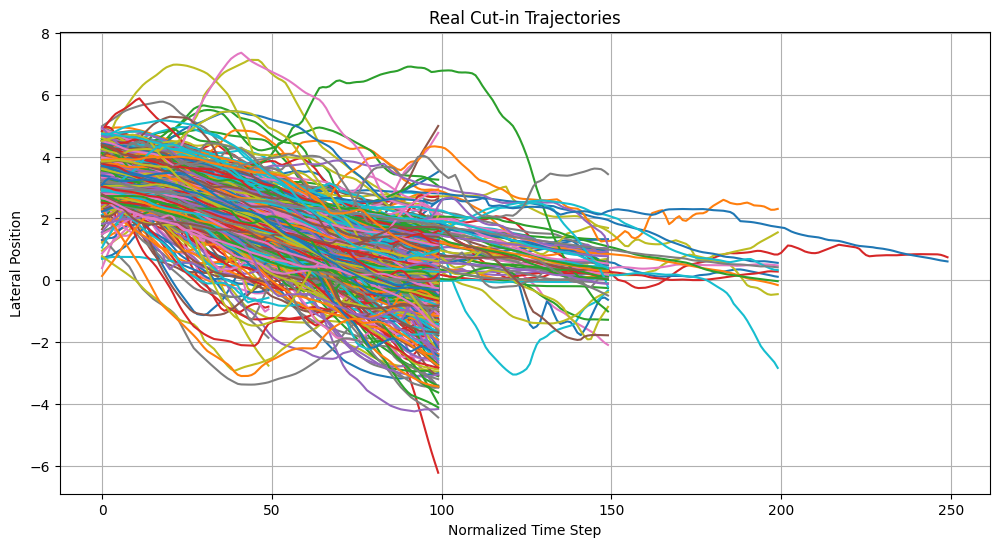

In [5]:
plt.figure(figsize=(12, 6))
for traj in trajectory_list_inter:
    plt.plot(traj, label="Real")
plt.title("Real Cut-in Trajectories")
plt.xlabel("Normalized Time Step")
plt.ylabel("Lateral Position")
plt.grid(True)
plt.show()


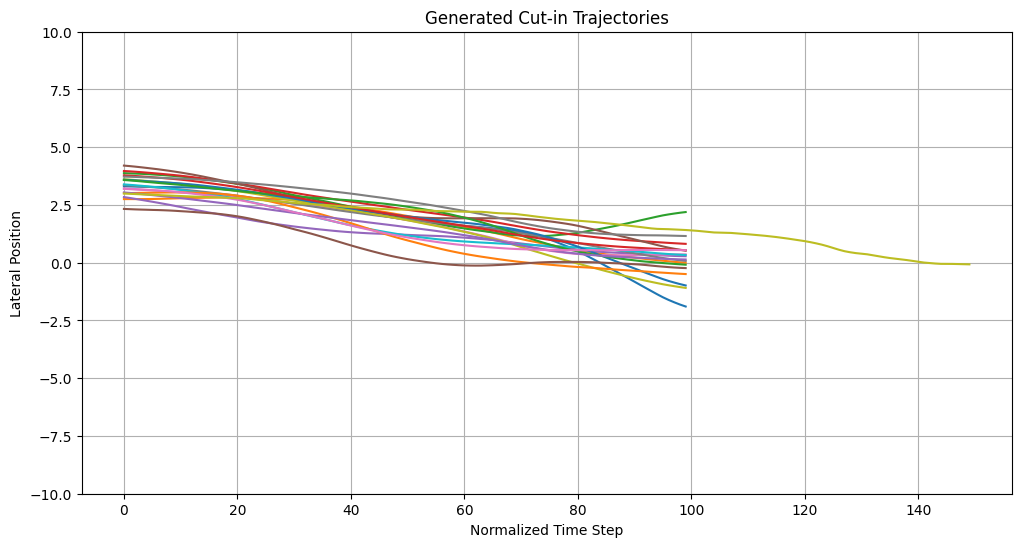

In [9]:
plt.figure(figsize=(12, 6))
for traj in sampled_trajectories:
    plt.plot(traj.squeeze(), label="Generated")
plt.title("Generated Cut-in Trajectories")
plt.xlabel("Normalized Time Step")
plt.ylabel("Lateral Position")
plt.grid(True)
plt.ylim(-10, 10)
plt.show()

number of filtered sample: 18 / 19


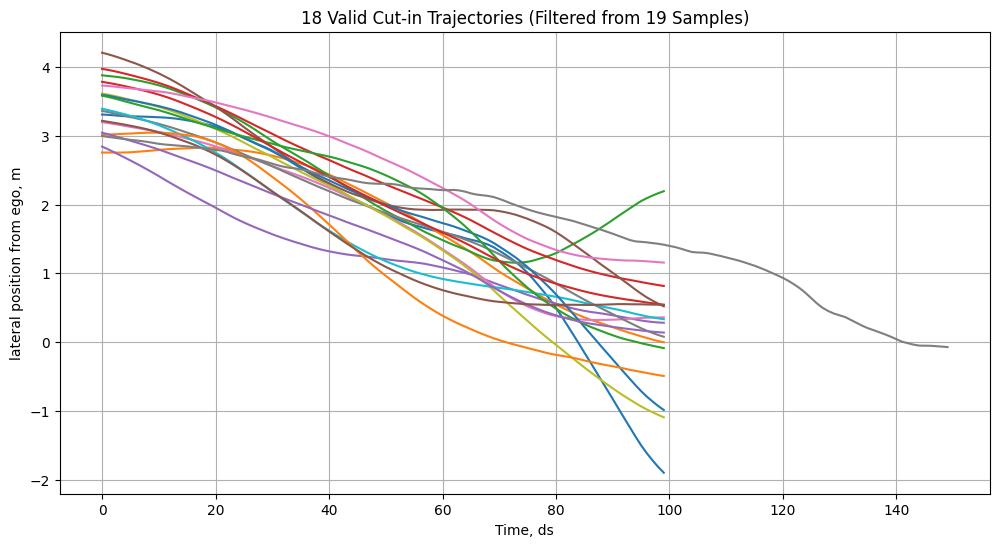

In [10]:
def is_cutin_trajectory(traj):
    traj = np.array(traj)
    min_dist_lat = np.min(np.abs(traj))
    std_dev_lat = np.std(traj)

    n = int(np.ceil(len(traj) / 2))
    first_half = traj[:n]
    second_half = traj[n:]

    diff_y = np.diff(traj)
    max_diff = np.max(np.abs(diff_y))

    max_lateral_movement = np.max(np.abs(traj)) - np.min(np.abs(traj))
    mean_first = np.mean(np.abs(first_half))
    mean_second = np.mean(np.abs(second_half))

    is_cut_out = mean_first < mean_second

    is_cutin = (
        std_dev_lat > 0.5 and
        min_dist_lat < 2 and
        max_diff < 0.5 and
        not is_cut_out and
        np.max(np.abs(traj)) > 2.5 and
        max_lateral_movement > 2.5
    )
    return is_cutin

filtered_samples = [traj.squeeze() for traj in sampled_trajectories if is_cutin_trajectory(traj.squeeze())]
num_valid = len(filtered_samples)
print(f"number of filtered sample: {num_valid} / {len(sampled_trajectories)}")

plt.figure(figsize=(12, 6))
for traj in filtered_samples:
    plt.plot(traj)
plt.title(f"{num_valid} Valid Cut-in Trajectories (Filtered from {len(sampled_trajectories)} Samples)")
plt.xlabel("Time, ds")
plt.ylabel("lateral position from ego, m")
plt.grid(True)
plt.show()